In [1]:
import numpy as np
from skimage.io import imread
from scipy.interpolate import NearestNDInterpolator
from tqdm import tqdm_notebook as tqdm 
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from skimage.transform import radon, iradon

from utils import GSW
import torch

In [8]:
I = imread('./figs/3gaussians.png').mean(2) / 128.
I = I[:, np.arange(219, -1, -1)]

m, n = I.shape

gridx, gridy = np.meshgrid(np.linspace(-int(m / 2), int(m / 2), 100),
                           np.linspace(-int(n / 2), int(n / 2), 100))

gridvec = np.concatenate((np.reshape(gridx, -1)[:, np.newaxis],
                          np.reshape(gridy, -1)[:, np.newaxis]), 1)

In [9]:
def sample_pdf(N):
    out = np.zeros((N, 2))
    for n in range(N):
        coin = np.random.rand(1)
        if coin >= .5:
            out[n, :] = np.random.randn(1, 2) * 10 - 45. + 110.
        elif coin >= (1. / 6.):
            out[n, :] = np.random.randn(1, 2) * 6 + 16. + 110.
        else:
            out[n, :] = np.random.randn(1, 2) * 1 + 68. + 110.
    return out

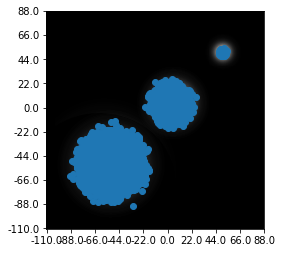

In [11]:
temp=sample_pdf(100000).astype(np.float32)
m, n = I.shape
plt.imshow(I, cmap='gray', origin=[110, 110])
plt.xticks(np.linspace(0, m, num=10), np.linspace(-int(m / 2), int(m / 2), num=11))
plt.yticks(np.linspace(0, n, num=10), np.linspace(-int(n / 2), int(n / 2), num=11))
plt.scatter(temp[:, 0], temp[:, 1])
plt.show()

45


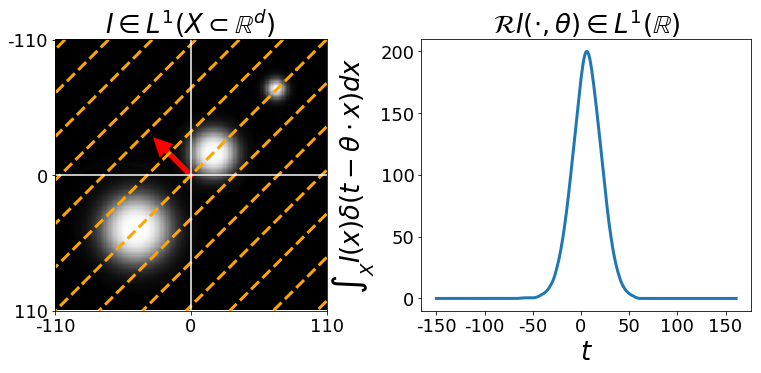

90


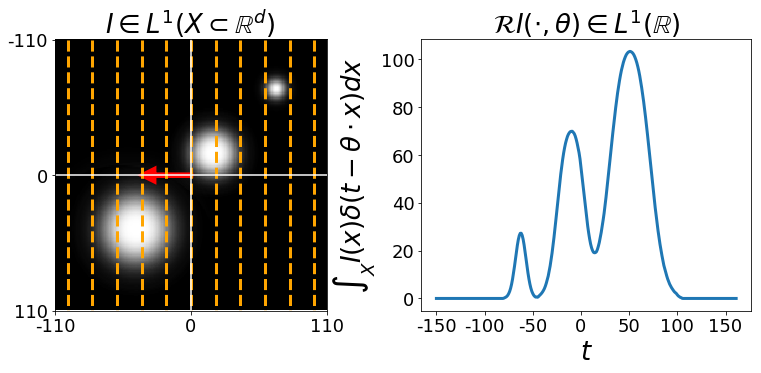

135


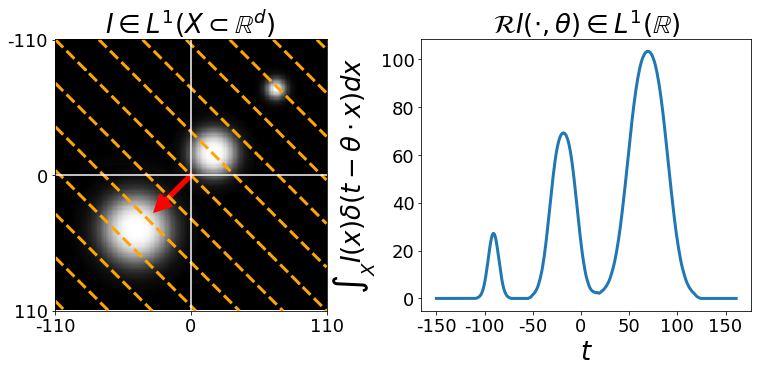

180


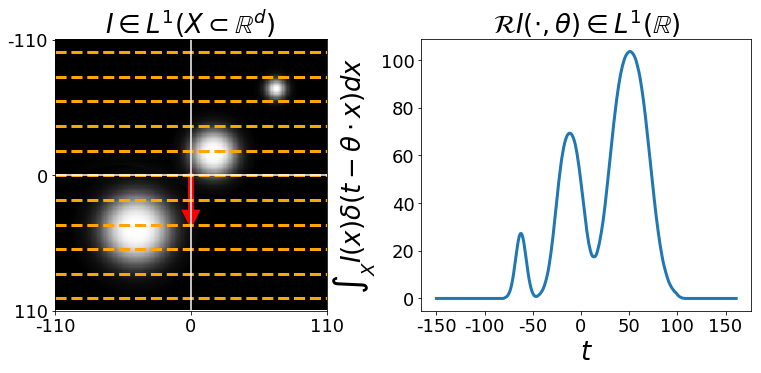

In [12]:
def f(X, rho):
    theta = np.array([np.cos(-(np.pi / 2.) - np.pi * rho / 180.),
                      np.sin(-(np.pi / 2.) - np.pi * rho / 180.)])
    return np.matmul(X, theta).squeeze()

for n, theta in enumerate(np.arange(45, 181, 45)):
    print(theta)
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    Itemp = I.copy()
    Itemp = Itemp[np.arange(219, -1, -1), :]

    ax[0].imshow(Itemp, cmap='gray')

    # Plot x and y axis
    ax[0].plot([110, 110], [0, 220], '-', c='w')
    ax[0].plot([0, 220], [110, 110], '-', c='w')

    # Plot project lines
    CS = ax[0].contour(gridx + 110, gridy + 110, np.reshape(f(gridvec, theta), (100, 100)), 
                       12, colors="orange", linestyles="--", linewidths=3)

    # Plot the arrow
    l = 30
    ax[0].arrow(110, 110,
                l * np.cos(-(np.pi / 2.) - np.pi * theta / 180.),
                l * np.sin(-(np.pi / 2.) - np.pi * theta / 180.),
                color='red', capstyle='projecting',
                head_width=9, head_length=9, linewidth=5)

    # Disable ticks
    ax[0].set_xticks(np.linspace(0, 220, 3).astype('int'))
    ax[0].set_xticklabels([-110, 0, 110])
    ax[0].set_yticks(np.linspace(0, 220, 3).astype('int'))
    ax[0].set_yticklabels([-110, 0, 110])
    ax[0].set_title(r'$I\in L^1(X\subset \mathbb{R}^d)$', fontsize=26)

    # Labels
    ax[1].plot(radon(I, [theta], circle=False)[:, 0], linewidth=3)
    ax[1].set_xticks(np.arange(0, 312, 50).astype('int'))
    ax[1].set_xticklabels(np.arange(-150, 155, 50).astype('int'))
    for i in range(2):
        ax[i].tick_params(axis='x', which='major', labelsize=18)
        ax[i].tick_params(axis='y', which='major', labelsize=18)

    # Latex labels
    ax[1].set_ylabel(r'$\int_X I(x)\delta(t-{\theta}\cdot x)dx$', fontsize=26)
    ax[1].set_xlabel(r'$t$', fontsize=26)
    ax[1].set_title(r'$\mathcal{R}I(\cdot,\theta) \in L^1(\mathbb{R})$', fontsize=26)

    plt.show()

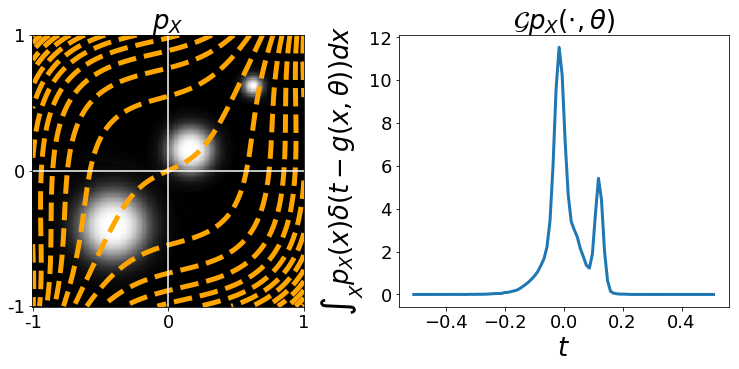

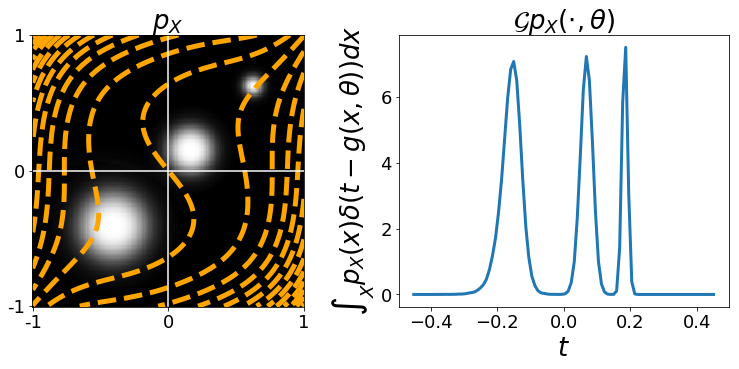

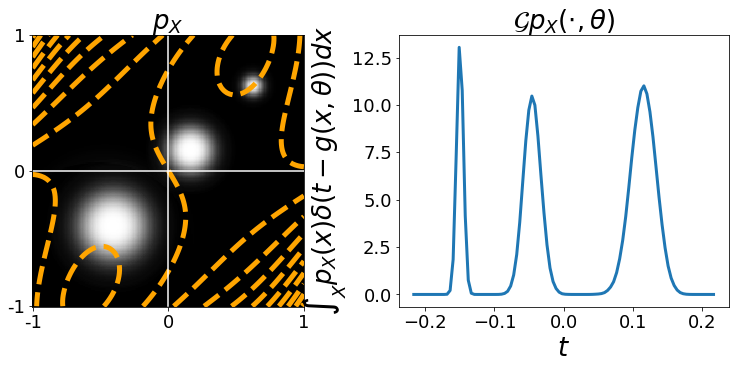

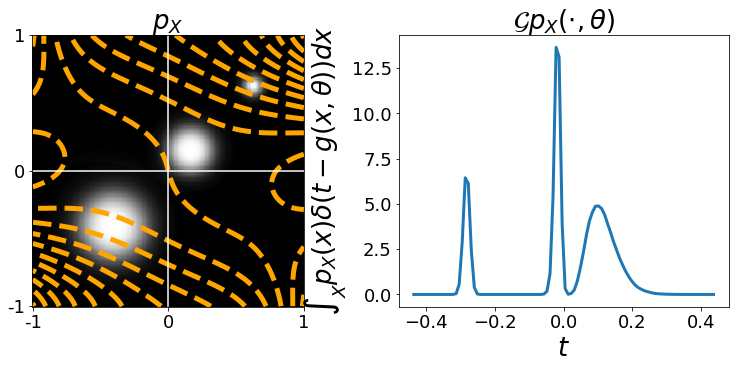

In [13]:
nofprojections = 4

gsw = GSW(ftype='poly', nofprojections=nofprojections, degree=5)
theta = gsw.random_slice(2)
projs = gsw.get_slice(torch.from_numpy((temp - 110) / 110.), theta).cpu().numpy()
fgridvec = gsw.get_slice(torch.from_numpy((gridvec) / 110.), theta).cpu().numpy()

for k in range(nofprojections):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    ax[0].imshow(I, cmap='gray', origin=[110, 110])
    ax[0].plot([110, 110], [0, 220], '-', c='w')
    ax[0].plot([0, 220], [110, 110], '-', c='w')
    ax[0].contour(gridx + 110, gridy + 110,
                  np.reshape(fgridvec[:, k], (100, 100)),
                  25, colors='orange', linewidths=5, linestyles='--')
    ax[0].set_xticks(np.linspace(0, 220, 3).astype('int'))
    ax[0].set_xticklabels([-1, 0, 1])
    ax[0].set_yticks(np.linspace(0, 220, 3).astype('int'))
    ax[0].set_yticklabels([-1, 0, 1])
    ax[0].set_title(r'$p_X$', fontsize=26)

    bw = projs[:, k].std() / 25.
    kz1 = KernelDensity(bandwidth=bw).fit(projs[:, k, np.newaxis])
    a = max(abs(projs[:, k].min()), abs(projs[:, k]).max())
    t = np.linspace(-1.2 * a, 1.2 * a, 100)
    pz1 = np.exp(kz1.score_samples(t[:, np.newaxis]))

    ax[1].plot(t, pz1, linewidth=3)
    ax[1].set_ylabel(r'$\int_X p_X(x)\delta(t- g(x,\theta))dx$', fontsize=26)
    ax[1].set_xlabel(r'$t$', fontsize=26)
    ax[1].set_title(r'$\mathcal{G}p_X(\cdot,\theta)$', fontsize=26)

    for i in range(2):
        ax[i].tick_params(axis='x', which='major', labelsize=18)
        ax[i].tick_params(axis='y', which='major', labelsize=18)

    plt.show()